In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
from shapely.geometry import shape, Point
import rasterio.features
from osgeo import gdal, osr

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the KDE pickle file
with open('../Outputs/KDE_output_200m.pickle', 'rb') as f:
    kde_200 = pickle.load(f)

kde_200.shape

(2500, 2500)

In [5]:
#import brooklyn's boundary shape
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry = bk_bndry.to_crs(32618)
bk_bndry.head()

,FID,geometry
0,0,"MULTIPOLYGON (((584478.960 4491458.524, 584470..."


In [8]:
output_raster_path = '../Outputs/KDE_200m_raster_output.tif'

In [9]:
#convert to raster to use with geo shape files
# Define the minimum and maximum bounds of the raster
#change this to the bk boundary shapefile
min_x, min_y, max_x, max_y = bk_bndry.total_bounds

width = 2500
height = 2500
pixel_width = (max_x - min_x) / width
pixel_height = (max_y - min_y) / height
#define spatial reference
srs = osr.SpatialReference()
srs.ImportFromEPSG(32618) 
#create raster
driver = gdal.GetDriverByName('GTiff')
output_raster = driver.Create(output_raster_path, width, height, 1, gdal.GDT_Float32)

# Set the raster's geotransform (georeferencing information)
output_raster.SetGeoTransform((min_x, pixel_width, 0, max_y, 0, -pixel_height))

# Set the raster's spatial reference system (SRS)
if srs is not None:
    output_raster.SetProjection(srs.ExportToWkt())

# Write the array data to the raster
band = output_raster.GetRasterBand(1)
band.WriteArray(kde_200)

# Save and close the raster file
output_raster.FlushCache()
output_raster = None

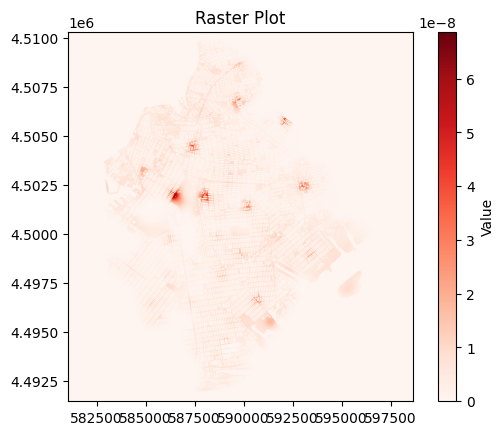

In [14]:
#check output
# Open the saved raster file
with rasterio.open(output_raster_path) as src:
    raster_array = src.read(1)

# Plot the raster array
plt.imshow(raster_array, cmap='Reds',extent=[min_x, max_x, min_y, max_y])
plt.colorbar(label='Value')
plt.title('Raster Plot')
plt.show()